# Промежуточная аттестация №3

# Часть первая "Построение моделей с помощью алгоритмов классического машинного обучения в ручную"

Описание работы
- Набор данных выбран "боевой" из повседневной практики, немного укороченный (по периоду) для скорости обработки. 
- Особенностью является то, что почти все столбцы категориальные.
- Требуется выполнить многоклассовую классификацию с целью определить исполнителя(бригаду) выполняюшую технологическую операцию. 
- Работоспособным будет считаться accuracy 0.80.
- Буду обучать модели алгоритмами: 
    - Метод KNN;
    - Random forest классификатор;
    - xgboost;
    - lightgbm;
    - catboost.

### Импорт библиотек

In [1]:
# Импорт библиотек
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import zipfile
import os
import time

import joblib
import json

from numba import cuda

from sklearn.preprocessing import LabelEncoder
from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb

from catboost import Pool, CatBoostClassifier

## Подготовка данных

### Загрузка исходных данных

In [2]:
# Загрузка файла с данными из архива
archive_path = 'data/completed_works.zip'
with zipfile.ZipFile(archive_path, 'r') as archive:
 
    with archive.open('completed_works.csv') as file:
        df = pd.read_csv(file, delimiter=';', encoding='cp1251')

### Подготовка исходных данных

In [3]:
# Переименование столбцов
df.columns = df.columns.str.replace(r'\(', '_', regex=True)
df.columns = df.columns.str.replace(r'\)', '', regex=True)
df.columns = df.columns.str.lower().str.replace(' ', '_')

# Стобец id 
df = df.rename(columns={'___': 'id'})
df.set_index('id', inplace=True)

df.info() # Вывод столбцов и их типов

<class 'pandas.core.frame.DataFrame'>
Index: 3617 entries, 961 to 1359
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   worker_name        3617 non-null   object
 1   hire_name          3617 non-null   object
 2   hire_height        3617 non-null   object
 3   hire_width         3617 non-null   int64 
 4   is_cnc             3617 non-null   int64 
 5   trade_code         3617 non-null   int64 
 6   tool_operation_id  3617 non-null   int64 
 7   oper_group_id      3617 non-null   int64 
 8   num                3617 non-null   int64 
dtypes: int64(6), object(3)
memory usage: 282.6+ KB


In [ ]:
df.head()

,worker_name,hire_name,hire_height,hire_width,is_cnc,trade_code,tool_operation_id,oper_group_id,num
id,,,,,,,,,
961,Бригада Тремасова,Швеллер,12П,0,0,1368,35,65,15
1877,Бригада Тремасова,Швеллер,12,0,0,1368,35,62,24
517,Бригада Тремасова,Швеллер,20У,0,0,1368,35,62,30
962,Бригада Тремасова,Швеллер,12П,0,0,1368,35,62,3
1926,Бригада Тремасова,Уголок,40,40,0,1368,35,62,6


In [5]:
# Статистические характеристики
df.describe()

,hire_width,is_cnc,trade_code,tool_operation_id,oper_group_id,num
count,3617.000000,3617.000000,3617.000000,3617.000000,3617.000000,3617.000000
mean,98.913464,0.101465,1300.670722,34.423002,256.787669,68.638374
std,179.929634,0.301986,289.686095,45.307482,582.092794,335.946283
min,0.000000,0.000000,0.000000,21.000000,21.000000,1.000000
25%,0.000000,0.000000,1367.000000,21.000000,35.000000,5.000000
50%,20.000000,0.000000,1368.000000,34.000000,41.000000,12.000000
75%,130.000000,0.000000,1378.000000,35.000000,64.000000,32.000000
max,1610.000000,1.000000,1498.000000,568.000000,2139.000000,8672.000000


### Описание столбцов
- id - идентификатор
- worker_name название бригады (target)	
- hire_name условно название проката (формы) материала заготовки - категориальный
- hire_height условно высота заготовки - категориальный
- hire_width условно ширина заготовки - категориальный
- is_cnc признак обработки на станке с ЧПУ - числовой
- trade_code код профессии - категориальный
- operation_id код операции	 - категориальный. Сильный для обучения. В продакшене часто появляются новые значения
- tool_operation_id тип операции - категориальный
- oper_group_id группа операции - категориальный
- num  количество выполненных операций - числовой

In [6]:
# Уменьшу размер на всякий случай
df['is_cnc'] = df['is_cnc'].astype('int32')
df['num'] = df['num'].astype('int32')
df['hire_width'] = df['hire_width'].astype('int32')
df['trade_code'] = df['trade_code'].astype('int32')
df['tool_operation_id'] = df['tool_operation_id'].astype('int32')
df['oper_group_id'] = df['oper_group_id'].astype('int32')

Анализ данных: 
- Пропусков нет
- Все столобцы кроме is_cnc и num являются категориальными
- Выбросы в данном df важны и удалению не подлежат
- 0 значения допускаются (например обработка сборочного узла)

### Подготовка столбца "worker_name"
- Является целевой переменной
- Кодирую LabelEncoder

In [7]:
# LabelEncoder к worker_name
label_encoder = LabelEncoder()
df['worker_encoded'] = label_encoder.fit_transform(df['worker_name'])
dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

{'Бригада Долотовой': 0,
 'Бригада Еремина': 1,
 'Бригада Пасютина': 2,
 'Бригада Сатучина': 3,
 'Бригада Тремасова': 4}

### Подготовка столбцов с информацией о заготовках
- Так как оборудование в бригадах делится, в т.ч. по массо-габаритным параметрам допускаю сильное влияние на обучение
- В данные столбцы может попадать различная информация, часто с ошибками
- Выполню "Чистку данных" от мусорных значений
- Подозреваю что контактенация hire_name, hire_width, hire_height будет иметь больший вес при обучении. Создам доп. столбец.
- Ко всем столбцам применю частотное кодирование

In [8]:
unique_values = df['hire_name'].unique()
unique_values

array(['Швеллер', 'Уголок', 'Труба', 'Текстолит', 'Стеклотекстолит',
       'Пруток', 'Профиль', 'Полиэтилен', 'Плита полиэтиленовая', 'Плита',
       'Пластина', 'Листовое органическое стекло', 'Лист ромб', 'Лист',
       'Круг', 'Капролон',
       'Гр.II НВ <= 269 Вакуумированная выплавка УЗК 100%  Гр.3 ГОСТ 24507-80 Поковка круглая',
       'Гр.II НВ <= 269 (допускается замена на блюм ТУ 14-1-4492 того же сечения) Поковка квадратная',
       'Блюм гр. 1 УЗК ГОСТ 21120 (не допускается падение донного сигнала до 6 дБ и более), с контролем макроструктуры (допускается замена на поковку того же сечения)',
       'Блюм гр. 1 УЗК ГОСТ 21120 (не допускается падение донного сигнала до 6 дБ и более), (допускается замена на поковку того же сечения)',
       'Блюм', 'Блок', 'Шестигранник', 'Стержень', 'Стекло', 'Проволока',
       'Полоса', 'Квадрат', 'Втулка', 'Лента', 'Гетинакс', 'Кольцо'],
      dtype=object)

In [9]:
# Очистка названия проката от лишних слов и символов
df['hire_name'] = (
    df['hire_name']
    .str.extract(r'(?i)(Блюм)', expand=False)  
    .fillna(df['hire_name'])
)
df['hire_name'] = (
    df['hire_name']
    .str.extract(r'(?i)(поковка круглая)', expand=False)
    .fillna(df['hire_name'])
)

df['hire_name'] = (
    df['hire_name']
    .str.extract(r'(?i)(капролон)', expand=False)
    .fillna(df['hire_name'])
)

df['hire_name'] = (
    df['hire_name']
    .str.extract(r'(?i)(лист)', expand=False)
    .fillna(df['hire_name'])
)

# Превод проката в верхний регистр
df['hire_name'] = df['hire_name'].str.upper()

In [10]:
unique_values = df['hire_name'].unique()
unique_values

array(['ШВЕЛЛЕР', 'УГОЛОК', 'ТРУБА', 'ТЕКСТОЛИТ', 'СТЕКЛОТЕКСТОЛИТ',
       'ПРУТОК', 'ПРОФИЛЬ', 'ПОЛИЭТИЛЕН', 'ПЛИТА ПОЛИЭТИЛЕНОВАЯ', 'ПЛИТА',
       'ПЛАСТИНА', 'ЛИСТ', 'КРУГ', 'КАПРОЛОН', 'ПОКОВКА КРУГЛАЯ', 'БЛЮМ',
       'БЛОК', 'ШЕСТИГРАННИК', 'СТЕРЖЕНЬ', 'СТЕКЛО', 'ПРОВОЛОКА',
       'ПОЛОСА', 'КВАДРАТ', 'ВТУЛКА', 'ЛЕНТА', 'ГЕТИНАКС', 'КОЛЬЦО'],
      dtype=object)

In [11]:
# Создание столбца material
df['material'] = df['hire_name'].astype(str) + ' ' + df['hire_width'].astype(str) + ' ' + df['hire_height'].astype(str)

In [12]:
# Частотное кодирование для hire_name
freq = df['hire_name'].value_counts(normalize=True)

df['h_name_freq'] = df['hire_name'].map(freq)

print(df[['hire_name', 'h_name_freq']].head())

# Частотное кодирование для hire_width
freq = df['hire_width'].value_counts(normalize=True)

df['h_width_freq'] = df['hire_width'].map(freq)

print(df[['hire_width', 'h_width_freq']].head())

# Частотное кодирование для hire_height
freq = df['hire_height'].value_counts(normalize=True)

df['h_height_freq'] = df['hire_height'].map(freq)

print(df[['hire_height', 'h_height_freq']].head())

# Частотное кодирование для material
freq = df['material'].value_counts(normalize=True)

df['material_freq'] = df['material'].map(freq)

print(df[['material', 'material_freq']].head())

     hire_name  h_name_freq
id                         
961    ШВЕЛЛЕР     0.001935
1877   ШВЕЛЛЕР     0.001935
517    ШВЕЛЛЕР     0.001935
962    ШВЕЛЛЕР     0.001935
1926    УГОЛОК     0.009953
      hire_width  h_width_freq
id                            
961            0      0.490185
1877           0      0.490185
517            0      0.490185
962            0      0.490185
1926          40      0.022671
     hire_height  h_height_freq
id                             
961          12П       0.000553
1877          12       0.033177
517          20У       0.000276
962          12П       0.000553
1926          40       0.039536
           material  material_freq
id                                
961   ШВЕЛЛЕР 0 12П       0.000553
1877   ШВЕЛЛЕР 0 12       0.000276
517   ШВЕЛЛЕР 0 20У       0.000276
962   ШВЕЛЛЕР 0 12П       0.000553
1926   УГОЛОК 40 40       0.001659


### Подготовка столбца "tool_operation_id", "oper_group_id", "trade_code"
- Данные критерии определяют технологические особенности операции, и должны оказывать сильное влияние на предсказание таргета.
- Применяю TargetEncoder

In [13]:
encode_cols = ['tool_operation_id', 'oper_group_id', 'trade_code']

# Создание энкодера и применение ко всем столбцам
encoder = TargetEncoder(cols=encode_cols, handle_unknown='value')
df_encoded = encoder.fit_transform(df[encode_cols], df['worker_encoded'])

# Добавление столбцов в df
for col in encode_cols:
    df[f'{col}_encoded'] = df_encoded[col]

In [14]:
# Сохранение обработанного df в .prepared_data.csv 
df.to_csv('data/prepared_data.csv', index=False)

In [15]:
df_encoded = df[['worker_encoded',
                 'h_name_freq',
                 'h_width_freq',
                 'h_height_freq',
                 'material_freq',
                 'tool_operation_id_encoded', 
                 'oper_group_id_encoded',
                 'trade_code_encoded',
                 'is_cnc',
                 'num']].copy()

df_encoded.head()

,worker_encoded,h_name_freq,h_width_freq,h_height_freq,material_freq,tool_operation_id_encoded,oper_group_id_encoded,trade_code_encoded,is_cnc,num
id,,,,,,,,,,
961,4,0.001935,0.490185,0.000553,0.000553,3.657503,3.809524,3.671729,0,15
1877,4,0.001935,0.490185,0.033177,0.000276,3.657503,3.659950,3.671729,0,24
517,4,0.001935,0.490185,0.000276,0.000276,3.657503,3.659950,3.671729,0,30
962,4,0.001935,0.490185,0.000553,0.000553,3.657503,3.659950,3.671729,0,3
1926,4,0.009953,0.022671,0.039536,0.001659,3.657503,3.659950,3.671729,0,6


Удаление дубликатов записей

In [16]:
# Проверка на дубликаты записей 
df_duplicated = df_encoded[df_encoded.duplicated(keep=False)]
# Количество дублированных строк
duplicated_rows = len(df_duplicated)
df_rows = len(df_encoded)
print(f'Всего строк: {df_rows}')
print(f'Дублированных строк: {duplicated_rows}  {duplicated_rows/df_rows:.2%}')

Всего строк: 3617
Дублированных строк: 130  3.59%


In [17]:
df_encoded = df_encoded.drop_duplicates()  

Посмотрим корреляции:

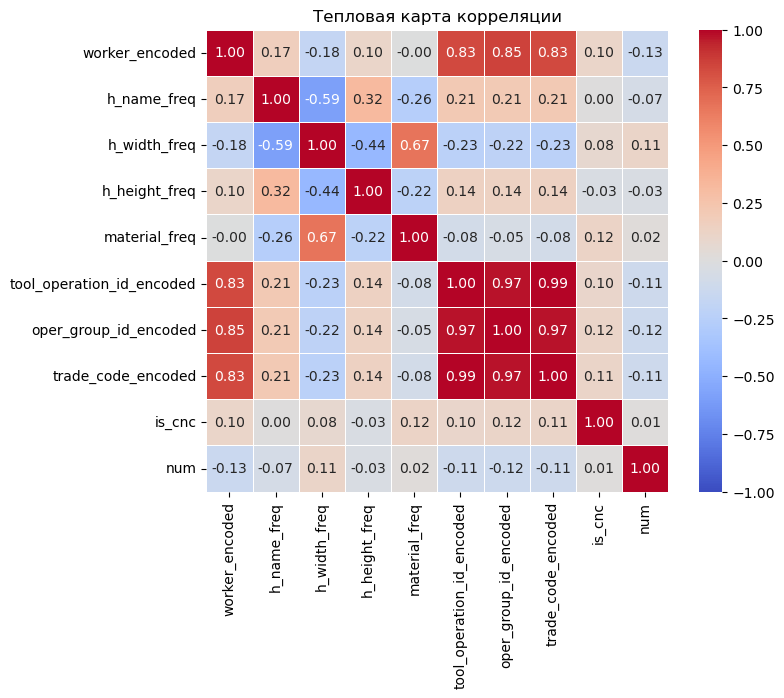

In [18]:
corr_matrix = df_encoded.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_matrix, 
    annot=True, 
    fmt=".2f",   
    cmap='coolwarm',  
    vmin=-1, vmax=1, 
    linewidths=0.5,   
    square=True        
)
plt.title('Тепловая карта корреляции')
plt.show()

- сильную корреляцию дают критерии связанные с технологической особенностью операции.
- информация о заготовке незначительную (ожидаемы результат от контактенации полей = 0), но исключать влияния нельзя.

## Обучение моделей

### Разделение/масштабирование

In [19]:
# Подготовка данных
X = df_encoded.drop('worker_encoded', axis=1)
y = df_encoded['worker_encoded']

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3, 
    random_state=42,
    stratify=y
)

# Масштабирование данных 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
all_results = [] # Переменная для общего итога

### KNN 

In [21]:
start_time = time.time()

# KNN классификатор
knn = KNeighborsClassifier()

# Параметры для подбора
param_grid = {
    'n_neighbors': range(3, 15),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree']
}

# Поиск по сетке
grid_search = GridSearchCV(
    knn, 
    param_grid, 
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)
grid_search.fit(X_train_scaled, y_train)

# Лучшая модель
best_knn = grid_search.best_estimator_
best_knn_params = grid_search.best_params_
best_knn_score = grid_search.best_score_

# Оценка на тестовых данных
y_pred = best_knn.predict(X_test_scaled)
y_proba = best_knn.predict_proba(X_test_scaled)  # Для ROC-AUC

# Метрики
report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
accuracy_knn = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Время обучения
training_time = time.time() - start_time

# Сохраняем результаты
knn_results = {
    'model_name': 'KNN',
    'model': best_knn,
    'best_params': best_knn_params,
    'cv_accuracy': best_knn_score,
    'test_accuracy': accuracy_knn,
    'classification_report': report,
    'confusion_matrix': conf_matrix,
    'training_time': training_time,
    'y_pred': y_pred,
    'y_proba': y_proba
}

all_results.append(knn_results) 

# Вывод результатов
print(f"Лучшие параметры: {best_knn_params}")
print(f"Лучшая точность (CV): {best_knn_score:.3f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=0))
print(f"\nTest Accuracy: {accuracy_knn:.3f}")
print(f"Training Time: {training_time:.2f} сек")

Лучшие параметры: {'algorithm': 'auto', 'metric': 'manhattan', 'n_neighbors': 12, 'weights': 'uniform'}
Лучшая точность (CV): 0.870

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.86      0.85       251
           1       0.92      0.97      0.94       218
           2       0.61      0.49      0.54        82
           3       0.93      0.96      0.94       234
           4       0.90      0.87      0.89       281

    accuracy                           0.88      1066
   macro avg       0.84      0.83      0.83      1066
weighted avg       0.87      0.88      0.87      1066


Test Accuracy: 0.878
Training Time: 4.00 сек


### RandomForestClassifier

In [22]:
start_time = time.time()

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'class_weight': ['balanced', None]
}

# Инициализация модели
rf = RandomForestClassifier(random_state=42)

# Поиск по сетке
grid_search = GridSearchCV(
    rf, 
    param_grid, 
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train, y_train)

# Лучшая модель
best_rf = grid_search.best_estimator_
best_rf_params = grid_search.best_params_
best_rf_score = grid_search.best_score_

# Оценка на тестовых данных
y_pred = best_rf.predict(X_test)
y_proba = best_rf.predict_proba(X_test)

# Метрики
report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
accuracy_rf = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Время обучения
training_time = time.time() - start_time

# Сохранение результатов
rf_results = {
    'model_name': 'Random Forest',
    'model': best_rf,
    'best_params': best_rf_params,
    'cv_accuracy': best_rf_score,
    'test_accuracy': accuracy_rf,
    'classification_report': report,
    'confusion_matrix': conf_matrix,
    'training_time': training_time,
    'y_pred': y_pred,
    'y_proba': y_proba
}

all_results.append(rf_results)

# Вывод результатов
print(f"\nЛучшие параметры: {best_rf_params}")
print(f"Лучшая точность (CV): {best_rf_score:.3f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=0))
print(f"\nTest Accuracy: {accuracy_rf:.3f}")
print(f"Training Time: {training_time:.2f} сек")

Fitting 5 folds for each of 24 candidates, totalling 120 fits

Лучшие параметры: {'class_weight': None, 'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}
Лучшая точность (CV): 0.893

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.85      0.87       251
           1       0.94      0.97      0.95       218
           2       0.65      0.68      0.67        82
           3       0.96      0.97      0.96       234
           4       0.91      0.91      0.91       281

    accuracy                           0.90      1066
   macro avg       0.87      0.88      0.87      1066
weighted avg       0.90      0.90      0.90      1066


Test Accuracy: 0.902
Training Time: 5.11 сек


### XGBoost

In [23]:
start_time = time.time()

# Вычисление весов классов
class_counts = np.bincount(y_train)
total_samples = len(y_train)
class_weights = total_samples / (len(class_counts) * class_counts)
weights_dict = {i: weight for i, weight in enumerate(class_weights)}

# Параметры для подбора
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01],
    'n_estimators': [100, 200],
    'scale_pos_weight': [None, list(weights_dict.values())],
    'min_child_weight': [1, 3]
}

# Инициализация модели
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',
    random_state=42,
    tree_method='hist',
    num_class=len(np.unique(y)),
    eval_metric='mlogloss'  # Добавляем метрику для многоклассовой задачи
)

# Поиск по сетке
grid_search = GridSearchCV(
    xgb_model,
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train, y_train)

# Лучшая модель
best_xgb = grid_search.best_estimator_
best_xgb_params = grid_search.best_params_
best_xgb_score = grid_search.best_score_

# Оценка на тестовых данных
y_pred = best_xgb.predict(X_test)
y_proba = best_xgb.predict_proba(X_test)

# Метрики
report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
accuracy_xgb = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Время обучения
training_time = time.time() - start_time

# Сохраняем результаты в словарь
xgb_results = {
    'model_name': 'XGBoost',
    'model': best_xgb,
    'best_params': best_xgb_params,
    'cv_accuracy': best_xgb_score,
    'test_accuracy': accuracy_xgb,
    'classification_report': report,
    'confusion_matrix': conf_matrix,
    'training_time': training_time,
    'y_pred': y_pred,
    'y_proba': y_proba
}

# Добавляем в общий список результатов
all_results.append(xgb_results)

# Вывод результатов
print(f"\nЛучшие параметры: {best_xgb_params}")
print(f"Лучшая точность (CV): {best_xgb_score:.3f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=0))
print(f"\nTest Accuracy: {accuracy_xgb:.3f}")
print(f"Training Time: {training_time:.2f} сек")


Fitting 5 folds for each of 48 candidates, totalling 240 fits

Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'scale_pos_weight': None}
Лучшая точность (CV): 0.897

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.84      0.87       251
           1       0.94      0.97      0.95       218
           2       0.64      0.71      0.67        82
           3       0.95      0.97      0.96       234
           4       0.91      0.90      0.90       281

    accuracy                           0.90      1066
   macro avg       0.87      0.88      0.87      1066
weighted avg       0.90      0.90      0.90      1066


Test Accuracy: 0.900
Training Time: 8.27 сек


### lightLGBM

In [24]:
import lightgbm as lgb
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.utils.class_weight import compute_class_weight  # Добавленный импорт
import time

start_time = time.time()

# Расчет весов классов
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', 
                                   classes=classes, 
                                   y=y_train)
weights_dict = {cls: weight for cls, weight in zip(classes, class_weights)}

# Параметры модели
params = {
    'objective': 'multiclass',
    'num_class': len(classes),
    'metric': 'multi_logloss',
    'boosting_type': 'gbdt',
    'random_state': 42,
    'verbose': -1,
    'class_weight': weights_dict  # Веса классов
}

# Параметры для GridSearch
param_grid = {
    'num_leaves': [31, 63, 127],
    'learning_rate': [0.1, 0.05, 0.01],
    'n_estimators': [50, 100, 200, 500],
    'min_child_samples': [20, 50],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [0, 0.1]
}

# Инициализация модели
lgb_model = lgb.LGBMClassifier(**params)

# Поиск по сетке
grid_search = GridSearchCV(
    lgb_model,
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Обучение модели
grid_search.fit(X_train, y_train)

# Лучшая модель
best_lgb = grid_search.best_estimator_
best_lgb_params = grid_search.best_params_
best_lgb_score = grid_search.best_score_

# Оценка на тестовых данных
y_pred = best_lgb.predict(X_test)
y_proba = best_lgb.predict_proba(X_test)

# Метрики
report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
accuracy_lgb = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Время обучения
training_time = time.time() - start_time

# Сохранение результатов
lgb_results = {
    'model_name': 'LightGBM',
    'model': best_lgb,
    'best_params': best_lgb_params,
    'cv_accuracy': best_lgb_score,
    'test_accuracy': accuracy_lgb,
    'classification_report': report,
    'confusion_matrix': conf_matrix,
    'training_time': training_time,
    'y_pred': y_pred,
    'y_proba': y_proba,
    'feature_importances': {
        'features': X_train.columns.tolist(),
        'importance_values': best_lgb.feature_importances_
    }
}

all_results.append(lgb_results)

# Вывод результатов
print(f"\nЛучшие параметры: {best_lgb_params}")
print(f"Лучшая точность (CV): {best_lgb_score:.3f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=0))
print(f"\nTest Accuracy: {accuracy_lgb:.3f}")
print(f"Training Time: {training_time:.2f} сек")

Fitting 5 folds for each of 288 candidates, totalling 1440 fits

Лучшие параметры: {'learning_rate': 0.05, 'min_child_samples': 50, 'n_estimators': 100, 'num_leaves': 63, 'reg_alpha': 0.1, 'reg_lambda': 0.1}
Лучшая точность (CV): 0.892

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.80      0.86       251
           1       0.95      0.97      0.96       218
           2       0.57      0.80      0.67        82
           3       0.97      0.96      0.96       234
           4       0.91      0.89      0.90       281

    accuracy                           0.89      1066
   macro avg       0.86      0.88      0.87      1066
weighted avg       0.90      0.89      0.90      1066


Test Accuracy: 0.893
Training Time: 736.00 сек


### CatBoost

In [25]:
# Обучение на некодированных категориальных переменных
# Загрузка и подготовка данных
df = pd.read_csv('data/prepared_data.csv')

# Колонки
required_cols = [
    'hire_name', 'hire_height', 'hire_width', 'is_cnc', 'trade_code',
    'tool_operation_id', 'oper_group_id', 'worker_encoded', 'num', 'material'
]

# Удаление дубликатов
df = df[required_cols].drop_duplicates()

# Разделение данных
X = df.drop('worker_encoded', axis=1)
y = df['worker_encoded']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Расчет весов классов
classes, class_counts = np.unique(y_train, return_counts=True)

class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weights_list = list(class_weights)

# Категориальные признаки
cat_features = [
    'hire_name', 'hire_height', 'hire_width', 'trade_code',
    'tool_operation_id', 'oper_group_id', 'material'
]

# Параметры модели
base_params = {
    'task_type': 'GPU',
    'loss_function': 'MultiClass',
    'iterations': 1000,
    'early_stopping_rounds': 50,
    'random_seed': 42,
    'verbose': 0,
    'auto_class_weights': 'Balanced',
    'gpu_ram_part': 0.85,
    'border_count': 128,
    'thread_count': 8
}

param_grid = {
    'depth': [6, 8, 10],
    'learning_rate': [0.01, 0.05, 1],
    'l2_leaf_reg': [3, 5]
}

# Обучение модели
start_time = time.time()

grid_search = GridSearchCV(
    estimator=CatBoostClassifier(**base_params),
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=1,
    verbose=0
)

grid_search.fit(X_train, y_train, cat_features=cat_features)

best_catboost = grid_search.best_estimator_

y_pred = best_catboost.predict(X_test)
y_proba = best_catboost.predict_proba(X_test)

# Сохранение результатов в общий список
catboost_results = {
    'model_name': 'CatBoost',
    'model': best_catboost,
    'best_params': grid_search.best_params_,
    'cv_accuracy': grid_search.best_score_,
    'test_accuracy': accuracy_score(y_test, y_pred),
    'classification_report': classification_report(y_test, y_pred, output_dict=True, zero_division=0),
    'confusion_matrix': confusion_matrix(y_test, y_pred),
    'training_time': time.time() - start_time,
    'y_pred': y_pred,
    'y_proba': y_proba,
    'feature_importances': {
        'features': X_train.columns.tolist(),
        'importance_values': best_catboost.get_feature_importance().tolist()
    }
}

# Добавление в общий список результатов
all_results.append(catboost_results)

# Вывод результатов
print(f"{'CatBoost Результаты':^50}")
print(f"\nЛучшие параметры: {grid_search.best_params_}")
print(f"Accuracy (CV): {grid_search.best_score_:.4f}")
print(f"Accuracy (Test): {accuracy_score(y_test, y_pred):.4f}")
print(f"\nВремя обучения: {catboost_results['training_time']:.2f} сек")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

               CatBoost Результаты                

Лучшие параметры: {'depth': 6, 'l2_leaf_reg': 3, 'learning_rate': 0.05}
Accuracy (CV): 0.8831
Accuracy (Test): 0.8982

Время обучения: 1445.13 сек

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.84      0.88       253
           1       0.95      0.97      0.96       218
           2       0.62      0.79      0.69        81
           3       0.93      0.96      0.95       235
           4       0.91      0.88      0.89       284

    accuracy                           0.90      1071
   macro avg       0.87      0.89      0.87      1071
weighted avg       0.90      0.90      0.90      1071



### Сохранение моделей

In [26]:

# Папка для моделей
os.makedirs('models', exist_ok=True)

for model_result in all_results:
    # Подпапка для модели
    model_name = model_result['model_name'].lower()
    model_dir = os.path.join('models', model_name)
    os.makedirs(model_dir, exist_ok=True)
    
    # Сохрание модели
    model_path = os.path.join(model_dir, f'{model_name}_model.pkl')
    joblib.dump(model_result['model'], model_path)
    
    print(f'Сохранено: {model_name} -> {model_dir}')

Сохранено: knn -> models\knn
Сохранено: random forest -> models\random forest
Сохранено: xgboost -> models\xgboost
Сохранено: lightgbm -> models\lightgbm
Сохранено: catboost -> models\catboost


## Выводы по моделям с "ручным" обучением

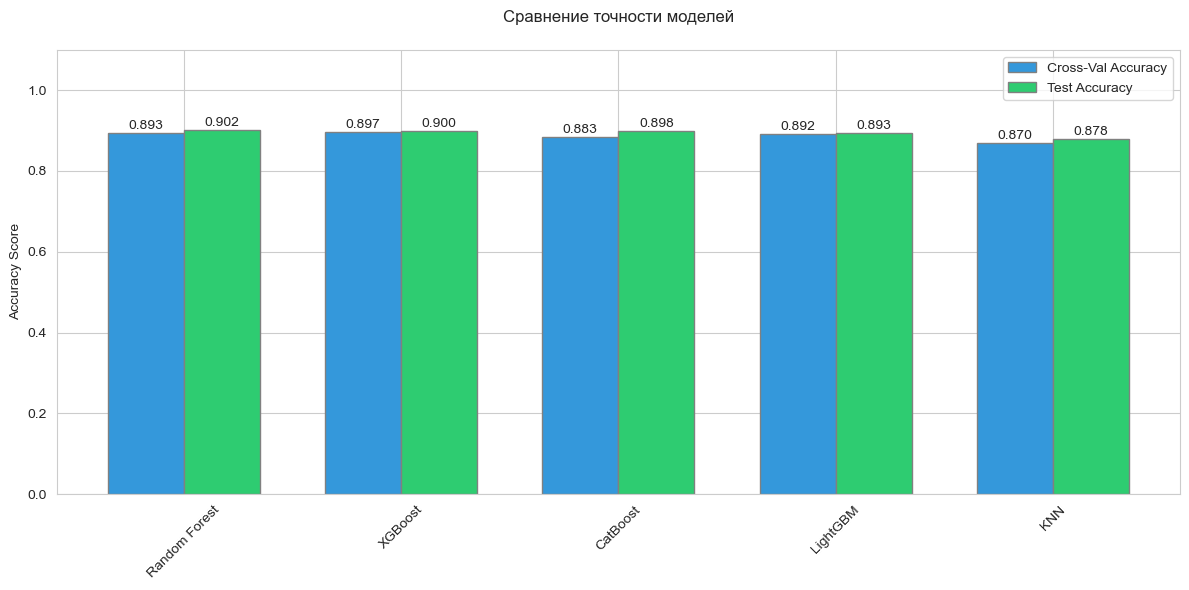

In [27]:
# DataFrame с метриками
metrics_df = pd.DataFrame([{
    'Model': res['model_name'],
    'CV Accuracy': res['cv_accuracy'],
    'Test Accuracy': res['test_accuracy'],
    'Training Time': res['training_time']
} for res in all_results])

# Сортирировка по Test Accuracy
metrics_df = metrics_df.sort_values('Test Accuracy', ascending=False)

# Настройка стиля
sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))

# Параметры столбцов
bar_width = 0.35
x_pos = range(len(metrics_df))

# Построение графиков
plt.bar(
    x_pos, 
    metrics_df['CV Accuracy'], 
    width=bar_width, 
    label='Cross-Val Accuracy',
    color='#3498db',
    edgecolor='grey'
)

plt.bar(
    [x + bar_width for x in x_pos], 
    metrics_df['Test Accuracy'], 
    width=bar_width, 
    label='Test Accuracy',
    color='#2ecc71',
    edgecolor='grey'
)

# Значения на столбцы
for i, (cv_acc, test_acc) in enumerate(zip(metrics_df['CV Accuracy'], metrics_df['Test Accuracy'])):
    plt.text(i, cv_acc + 0.01, f'{cv_acc:.3f}', ha='center')
    plt.text(i + bar_width, test_acc + 0.01, f'{test_acc:.3f}', ha='center')

# Оформление
plt.xticks([x + bar_width/2 for x in x_pos], metrics_df['Model'], rotation=45)
plt.ylabel('Accuracy Score')
plt.title('Сравнение точности моделей', pad=20)
plt.legend(frameon=True, loc='upper right')
plt.ylim(0, 1.1 if max(metrics_df[['CV Accuracy', 'Test Accuracy']].max()) < 1 else None)

plt.tight_layout()
plt.show()

In [28]:
# Вывод сводной таблицы
print("\nСравнительная таблица моделей:")
print(metrics_df.to_string(index=False))


Сравнительная таблица моделей:
        Model  CV Accuracy  Test Accuracy  Training Time
Random Forest     0.892958       0.902439       5.109849
      XGBoost     0.897384       0.899625       8.269899
     CatBoost     0.883110       0.898226    1445.132822
     LightGBM     0.891751       0.893058     735.998864
          KNN     0.870020       0.878049       4.002364


1. Вывод по оценки точности (Test Accuracy):
    - Random Forest лудшая точность на тестовых данных (90.24%)
    - XGBoost на втором месте с 89.96% (разница всего 0.28% с Random Forest)
    - CatBoost - 89.82% (почти идентично XGBoost)
    - LightGBM - 89.31%
    - KNN - 87.80% (наименьшая точность среди всех моделей)
2. Модели не переобучены учитывая незначительную разницу между CV Accuracy и Test Accuracy
3. Скорость обучения
    - KNN - самый быстрый (4.13 сек)
    - Random Forest (5.10 сек) лучшее соотношение точность/время
    - XGBoost - 8.00 сек 
    - CatBoost, несмотря на долгое обучение, не показал преимущества в точности. Не правильно подбираю параметры? Не настроил GPU?
4. Лидеры в данной оценке Random Forest, XGBoost

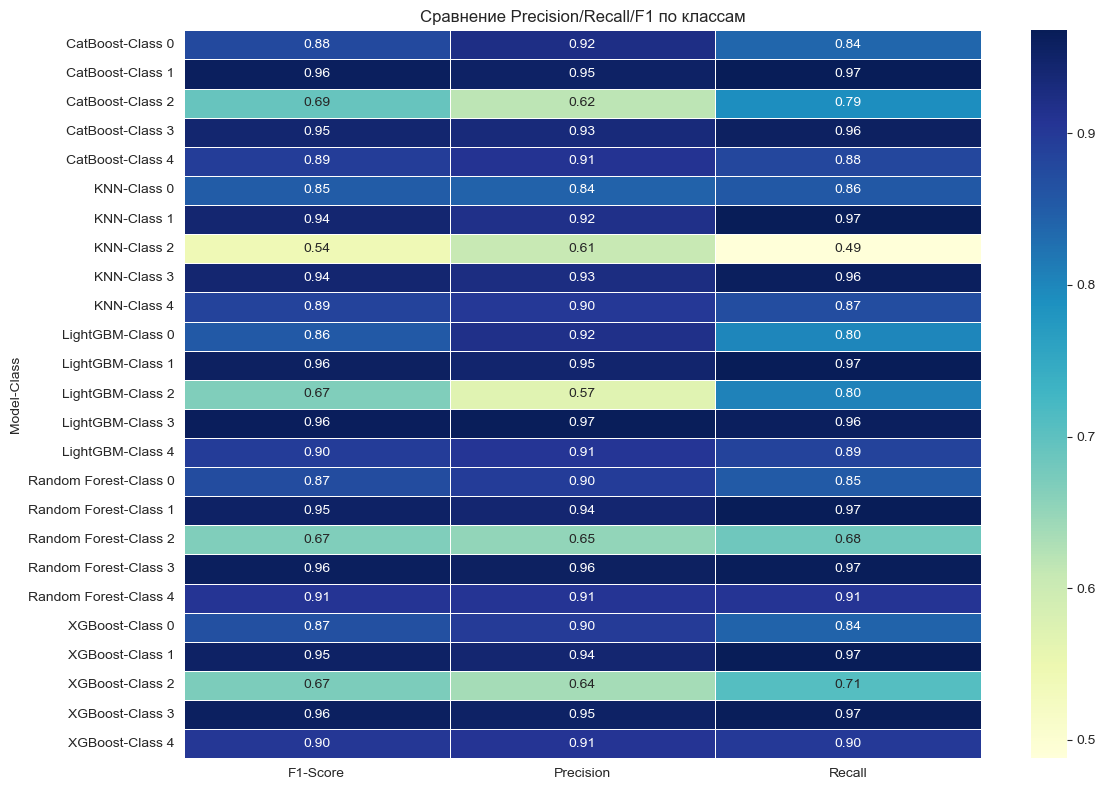

In [29]:
metrics = []
for model in all_results:
    report = model['classification_report']
    for class_name in report.keys():
        if class_name.isdigit():
            metrics.append({
                'Model': model['model_name'],
                'Class': f"Class {class_name}",
                'Precision': report[class_name]['precision'],
                'Recall': report[class_name]['recall'],
                'F1-Score': report[class_name]['f1-score']
            })

metrics_df = pd.DataFrame(metrics)

# Pivot-таблица для heatmap
heatmap_data = metrics_df.pivot_table(index=['Model', 'Class'], 
                                     values=['Precision', 'Recall', 'F1-Score'])

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu", linewidths=0.5)
plt.title("Сравнение Precision/Recall/F1 по классам")
plt.tight_layout()
plt.show()

### Анализ по классам
1. В основном предсказание по классам имеет хорошие результаты.
2. CatBoost — лучший баланс между Precision и Recall, особенно для проблемного класса.
3. Сложности с предсказанием класса 2.

### Проблеммы и решения
1. Малое количество записей для класса 2, "подтянуть" данные для этого класса за больший период;
2. Нехватает признаков (возможно следует добавить время выполнеия операции, текущую загрузку бригад и др.);
3. Подобрать гиперпараметры моделей более детально;
4. Подобрать веса классов в ручную;
5. Применить для категорий с массабабаритами TargetEncoding;
6. Применить ансамблирование CatBoost и например, Random Forest;
7. Использовать отдельную модель.
### В целом
- Проблеммы для класса 2 нужно решать, но при моей задаче (стратегическое (более года) планирование по бригадам) получился хороший результат!
- Для работы можно использовать CatBoost или XGBoost.

# Часть вторая "Построение моделей с помощью алгоритмов классического машинного обучения используя инструменты AutoML"

Описание работы
- Используется подготовленный набор данных из первой части. 
- Для обучения используется H2O

### Импорт библиотек

In [30]:
import h2o
from h2o.automl import H2OAutoML

### Подготовка данных

In [31]:
# Загрузка файла с данными из архива
df = pd.read_csv('data/prepared_data.csv')
# Убираю кодированные фичи
df_h2o = df[[
    "worker_name",
    "hire_name", 
    "hire_height", 
    "hire_width", 
    "trade_code",
    "tool_operation_id", 
    "oper_group_id", 
    "material", 
    "is_cnc", 
    "num"
]]
df_h2o.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3617 entries, 0 to 3616
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   worker_name        3617 non-null   object
 1   hire_name          3617 non-null   object
 2   hire_height        3617 non-null   object
 3   hire_width         3617 non-null   int64 
 4   trade_code         3617 non-null   int64 
 5   tool_operation_id  3617 non-null   int64 
 6   oper_group_id      3617 non-null   int64 
 7   material           3617 non-null   object
 8   is_cnc             3617 non-null   int64 
 9   num                3617 non-null   int64 
dtypes: int64(6), object(4)
memory usage: 282.7+ KB


## Обучение с использованием H2O

### Инициализация H2O, подготовка данных

In [32]:
# Инициализация
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.12+8-LTS-286, mixed mode, sharing)
  Starting server from C:\Users\21693\AppData\Local\anaconda3\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\21693\AppData\Local\Temp\tmpbqcymnrm
  JVM stdout: C:\Users\21693\AppData\Local\Temp\tmpbqcymnrm\h2o_21693_started_from_python.out
  JVM stderr: C:\Users\21693\AppData\Local\Temp\tmpbqcymnrm\h2o_21693_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Astrakhan
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.7
H2O_cluster_version_age:,11 days
H2O_cluster_name:,H2O_from_python_21693_za54wv
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.928 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


In [33]:
# Конвертация pandas DataFrame в H2OFrame
h2o_df = h2o.H2OFrame(df)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [34]:
# Преобразование категориальных фичей хранящихся цифрами в "факторы"
cat_cols = [
    "worker_name",
    "hire_name",  
    "hire_width", 
    "trade_code",
    "tool_operation_id", 
    "oper_group_id", 
    "material"
]
for col in cat_cols:
    h2o_df[col] = h2o_df[col].asfactor()

# Цель
target = "worker_name"

# Фичи
features = [ 
    "hire_name", 
    "hire_height", 
    "hire_width", 
    "trade_code",
    "tool_operation_id", 
    "oper_group_id", 
    "material"]

# Разделение на тренировочную/тестовую выборку
train, test = h2o_df.split_frame(ratios=[0.7], seed=42)

### Обучение AutoML

In [35]:
# Параметры AutoML
aml = H2OAutoML(
    max_models=10,
    seed=42,
    max_runtime_secs=300,
    balance_classes=True,
    nfolds=5,
    verbosity="False"
)

In [36]:
# Запуск обучения
aml.train(x=features, y=target, training_frame=train)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


key,value
Stacking strategy,cross_validation
Number of base models (used / total),10/10
# GBM base models (used / total),6/6
# DRF base models (used / total),2/2
# GLM base models (used / total),1/1
# DeepLearning base models (used / total),1/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5
Metalearner fold_column,None


### Сравнительная таблица с критериями качества по моделям

In [37]:
import warnings
warnings.filterwarnings("ignore") # Куча ошибок не влияющих на работу - отключу пока

lb = aml.leaderboard
print(lb.head())

model_id                                                   mean_per_class_error    logloss      rmse        mse
StackedEnsemble_AllModels_1_AutoML_1_20250407_162558                   0.137306   0.336789  0.305035  0.0930461
StackedEnsemble_BestOfFamily_1_AutoML_1_20250407_162558                0.138464   0.335061  0.305274  0.0931924
DRF_1_AutoML_1_20250407_162558                                         0.148287   0.423144  0.302884  0.0917388
GBM_1_AutoML_1_20250407_162558                                         0.148306   0.344975  0.307155  0.094344
GBM_2_AutoML_1_20250407_162558                                         0.148708   0.380243  0.315562  0.0995794
GBM_4_AutoML_1_20250407_162558                                         0.153114   0.401579  0.320673  0.102831
GBM_5_AutoML_1_20250407_162558                                         0.155235   0.386995  0.319698  0.102207
GLM_1_AutoML_1_20250407_162558                                         0.15808    0.375144  0.320786  0.102

### Вывод
1. Accuracy (общая точность):
- на тренировочных данных: 90.9%. Лучше чем лидер "ручного" обучения RF (90.24%)
- на кросс-валидации: 89.3% (устойчивость хорошая, разрыв 1.6%)
2. Анализ по классам 
- Лучшие классы:
    - Бригада Еремина: Error Rate = 4.7% (train), 5.1% (CV)
    - Бригада Сатучина: Error Rate = 2.4% (train), 2.4% (CV)
- Проблемные классы:
    - Бригада Пасютина: Error Rate = 8.2% (train) → 35.6% (CV). Сильное переобучение (разрыв 27.4%)
    - Бригада Тремасова: Error Rate = 11.5% (train), 13.7% (CV)
- Основные ошибки:
    - Бригада Долотовой часто путается с Бригадой Пасютина (75 ошибок на train).
    - Бригада Пасютина на CV ошибается в 35.6% случаев (58 из 194 предсказаны как "Бригада Долотовой").
3. Сильные стороны модели:
- высокая общая точность (89-91%)
- отличная предсказательная способность для 3 из 5 классов
- хорошая устойчивость (разрыв train/CV всего 1.6% по Accuracy)
4. Проблемы:
- критическая ошибка для "Бригады Пасютина" (35.6% на CV)
- сильное переобучение для этого класса
- проблема по классу 2 ("Бригады Пасютина") присутствует и в данной модели. Нужно балансировать данные!

#